In [403]:
module FractionalEM
  using GradientRobustMultiPhysics
  using ExtendableGrids
  using GridVisualize
  using ExtendableSparse
  using SpecialFunctions

  """
    ReactionConvectionDiffusionOperator(α, β, ϵ)

    TBW
  """
  function ReactionConvectionDiffusionOperator(γ, β, ϵ)
    function action_kernel!(result, input, x, t)
        β.x = x
        β.time = t
        eval_data!( γ )
        eval_data!( β )
        # α * u_h + β_1 * ∇_xu_h + β_2 ∇_y u_h
        result[1] = γ.val[1] * input[1] + β.val[1] * input[2] + β.val[2] * input[3]
        # Laplacian
        result[2] = ϵ * input[2]
        result[3] = ϵ * input[3]
        return nothing
    end
    action = Action(action_kernel!, [3, 3], dependencies = "XT", bonus_quadorder = max(γ.bonus_quadorder, β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity, Gradient}, OperatorPair{Identity, Gradient}], action;
    name=" ϵ(∇ u, ∇ v) + (γ u + β⋅∇u, v)", transposed_assembly = true)
  end

  """
    get_problem_data(ν)

  TBW
  """
  function get_problem_data(ϵ, p=1.0, α=1.0)
    γ = DataFunction([0.0]; name = "γ")
    β = DataFunction([0.0,0.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = x[1]*t^p
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        dt_u = x[1] * gamma(p+1)/gamma(p-α+1)*t^(p-α)
        result[1] = dt_u-ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # γ * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end 
  
  function main(; ϵ=1.0, nrefinements=2, nsteps=10, Tf=1.0, α=1, tpower=1.0, verbosity=0)
    aj = zeros(nsteps);     
    aj[1] = 1.0;
    for j = 2:nsteps
      aj[j] = (j)^(1-α) - (j-1)^(1-α)
    end
    @show aj
    bj = zeros(nsteps+1); 
    bj[1] = aj[1]
    bj[nsteps+1] = -aj[nsteps]
    for j=2:nsteps
      bj[nsteps-j+2]= aj[nsteps-j+2] - aj[nsteps-j+1]
    end
    @show bj    
    temp = sum(bj)
    @show temp # sum must be zero

    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    ## negotiate data functions to the package
    γ, β, u, ∇u, f = get_problem_data(ϵ, tpower, α)
    # choose a finite element type
    FEType = H1Pk{1,2,2}
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = FESpace{FEType}(xgrid)
    Solution = FEVector(FES)
    n_dofs = FES.ndofs
    interpolate!(Solution[1], u; time = 0.0)    

    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
    # @show M.entries
    # println(size(M[1,1]))
    @show FES.ndofs
    A = FEMatrix(FES)
    assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=0.0)
    # @show A.entries

    rhs = FEVector(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
    # @show rhs.entries

    dt = Array{BoundaryData,1}(undef,0)
    push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
    dofs = boundarydata!(Solution[1], dt; time = 0.0)
    
    t0 = 0.0
    tau = (Tf - t0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES.ndofs, 1)
    Mu0 = zeros(Float64, FES.ndofs)
    temp = zeros(Float64, FES.ndofs, nsteps)    
    temp[:, 1] = Solution[1].entries

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)

    # SolVector = Array{FEVector{Float64}}([])
    Sols = Array{FEVector}(undef, nsteps)
    # push!(SolVector, Solution)

    scale = tau^α*gamma(2-α)
    oldL2 = zero(Float64); oldh1 = zero(Float64)
    eL2 = zero(Float64); eh1 = zero(Float64)

    # for m in 1:nsteps + 1
    m = 1;
    # while t0 <= Tf - 1e-10
    #   t0 = t0 + tau
    #   m += 1
    #   println(m, " ", t0)
    #   for j in 2 : m-1
    #     println(m, " ", j, " ", m-j+1, " ", bj[m-j+1], " ", j-1)
    #   end
    #   println()
    # end

    for m=2:nsteps
      t0 = t0+tau
      fill!(SystemRHS.entries, 0)
      fill!(rhs.entries, 0)
      assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
      V1[:, 1] = rhs.entries
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
      @show aj[m-1]
      addblock!(SystemRHS[1], Mu0; factor= aj[m-1]/scale)
      for j=2:m-1
        # println(m," ", j, " ", m-j+1, " ", bj[m-j+1])
        addblock!(SystemRHS[1], M.entries*temp[:,j]; factor= -bj[m-j+1]/scale)
      end

      fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
      fill!(A.entries.cscmatrix.nzval, 0)
      # assembling the matrices with coefficients depending on time     
      assemble_operator!(A[1, 1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=t0 )
      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/scale)
      addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)

      flush!(SystemMatrix.entries)      
      #@show SystemRHS.entries
      dofs = boundarydata!(SystemSol[1], dt; time = t0)        
      for dof in dofs
        SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
        SystemMatrix[1,1][dof,dof] = 1e60
      end
      SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
      for j = 1 : n_dofs 
        Solution[1][j] = SystemSol[1][j]
      end
      # push!(SolVector, Solution)
      temp[:, m] = Solution[1].entries

      L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
      l2 = evaluate(L2Error_u, Solution[1])
      eL2 += (l2 + oldL2) * tau * 0.5
      oldL2 = l2

      h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
      h1 = evaluate(h1erro, Solution[1])
      eh1 += (l2 + oldh1) * tau * 0.5
      oldh1 = h1

      @show (sqrt(eL2), sqrt(eh1))
    end #endfor time 
    @show (sqrt(eL2))
    (sqrt(eL2), sqrt(eh1))
  end #end main 
end #module 

Main.FractionalEM

In [404]:
ns = [10 20 40 80 160]
eL2=[]; eH1=[];
for n in ns
    el2, eh1 = Main.FractionalEM.main(nsteps=n, α=0.3, tpower=2)
    push!(eL2, el2)
    push!(eH1, eh1)
end



aj = [1.0, 0.624504792712471, 0.5331644872621222, 0.4813465415711953, 0.44615349205425936, 0.4199747728071448, 0.3993846907155292, 0.3825650730224508, 0.36844287160090605, 0.3563356145266434]
bj = [1.0, -0.37549520728752905, -0.09134030545034877, -0.0518179456909269, -0.035193049516935915, -0.026178719247114568, -0.020590082091615614, -0.01681961769307838, -0.014122201421544744, -0.012107257074262634, -0.3563356145266434]
temp = 0.0
FES.ndofs = 

145


(nrefinements, nsteps) = (2, 10)
aj[m - 1] = 1.0


(sqrt(eL2), sqrt(eh1)) = (1.6463968375636984e-5, 1.6463968375636984e-5)
aj[m - 1] = 0.624504792712471
(sqrt(eL2), sqrt(eh1)) = (3.008801707117595e-5, 8.17992633721854e-5)
aj[m - 1] = 0.5331644872621222
(sqrt(eL2), sqrt(eh1)) = (4.0995018414890445e-5, 0.00012319673439750294)
aj[m - 1] = 0.4813465415711953
(sqrt(eL2), sqrt(eh1)) = (5.037659212976787e-5, 0.00015738709970141983)
aj[m - 1] = 0.44615349205425936
(sqrt(eL2), sqrt(eh1)) = (5.875752607530677e-5, 0.00018737784365426612)
aj[m - 1] = 0.4199747728071448
(sqrt(eL2), sqrt(eh1)) = (6.641485235653086e-5, 0.00021449131505224162)
aj[m - 1] = 0.3993846907155292
(sqrt(eL2), sqrt(eh1)) = (7.35161047696792e-5, 0.00023946194657087694)
aj[m - 1] = 0.3825650730224508
(sqrt(eL2), sqrt(eh1)) = (8.017197947828016e-5, 0.00026275137721034746)
aj[m - 1] = 0.36844287160090605
(sqrt(eL2), sqrt(eh1)) = (8.646027411675778e-5, 0.00028467350207102944)
sqrt(eL2) = 8.646027411675778e-5
aj = [1.0, 0.624504792712471, 0.5331644872621222, 0.4813465415711953, 0.4

1.0
(sqrt(eL2), sqrt(eh1)) = (3.5049765096752544e-6, 3.5049765096752544e-6)
aj[m - 1] = 0.624504792712471
(sqrt(eL2), sqrt(eh1)) = (6.421716148301e-6, 1.7448570377203357e-5)
aj[m - 1] = 0.5331644872621222
(sqrt(eL2), sqrt(eh1)) = (8.76979298286743e-6, 2.636245847414295e-5)
aj[m - 1] = 0.4813465415711953
(sqrt(eL2), sqrt(eh1)) = (1.0792816057028441e-5, 3.373776265171312e-5)
aj[m - 1] = 0.44615349205425936
(sqrt(eL2), sqrt(eh1)) = (1.260170163120563e-5, 4.021321221655749e-5)
aj[m - 1] = 0.4199747728071448
(sqrt(eL2), sqrt(eh1)) = (1.425542589537416e-5, 4.607106168411704e-5)
aj[m - 1] = 0.3993846907155292
(sqrt(eL2), sqrt(eh1)) = (1.5789763672064168e-5, 5.1468435738751134e-5)
aj[m - 1] = 0.3825650730224508
(sqrt(eL2), sqrt(eh1)) = (1.7228395318411576e-5, 5.650423901861176e-5)
aj[m - 1] = 0.36844287160090605


(sqrt(eL2), sqrt(eh1)) = (1.858798404866104e-5, 6.124579163127833e-5)
aj[m - 1] = 0.3563356145266434
(sqrt(eL2), sqrt(eh1)) = (1.9880797242400392e-5, 6.574149223837745e-5)
aj[m - 1] = 0.345784333211391
(sqrt(eL2), sqrt(eh1)) = (2.1116185557371036e-5, 7.00275800657664e-5)
aj[m - 1] = 0.33646669803214735
(sqrt(eL2), sqrt(eh1)) = (2.230147581977666e-5, 7.413205824645368e-5)
aj[m - 1] = 0.3281483522385127
(sqrt(eL2), sqrt(eh1)) = (2.3442539375245646e-5, 7.807711743427963e-5)
aj[m - 1] = 

0.32065399196485167
(sqrt(eL2), sqrt(eh1)) = (2.454416966751599e-5, 8.188070853183473e-5)
aj[m - 1] = 0.31384933975549956
(sqrt(eL2), sqrt(eh1)) = (2.5610342079722584e-5, 8.555760470238137e-5)
aj[m - 1] = 0.30762945489386784
(sqrt(eL2), sqrt(eh1)) = (2.6644398119132995e-5, 8.912014249934777e-5)
aj[m - 1] = 0.3019108960314183
(sqrt(eL2), sqrt(eh1)) = (2.7649179303088408e-5, 9.257875358708539e-5)
aj[m - 1] = 0.2966263147249997
(sqrt(eL2), sqrt(eh1)) = (2.8627126617663842e-5, 9.594235534950377e-5)
aj[m - 1] = 0.29172063281539984
(sqrt(eL2), sqrt(eh1)) = (2.958035581188826e-5, 9.921864376161202e-5)
sqrt(eL2) = 2.958035581188826e-5
aj = [1.0, 0.624504792712471, 0.5331644872621222, 0.4813465415711953, 0.44615349205425936, 0.4199747728071448, 0.3993846907155292, 0.3825650730224508, 0.36844287160090605, 0.3563356145266434, 0.345784333211391, 0.33646669803214735, 0.3281483522385127, 0.32065399196485167, 0.31384933975549956, 0.30762945489386784, 0.3019108960314183, 0.2966263147249997, 0.29172063

(sqrt(eL2), sqrt(eh1)) = (1.8693752973075315e-6, 5.621772765007583e-6)
aj[m - 1] = 0.4813465415711953
(sqrt(eL2), sqrt(eh1)) = (2.3046693496107716e-6, 7.209405795775161e-6)
aj[m - 1] = 0.44615349205425936
(sqrt(eL2), sqrt(eh1)) = (2.6943220403896975e-6, 8.604943140274704e-6)
aj[m - 1] = 0.4199747728071448
(sqrt(eL2), sqrt(eh1)) = (3.050821726217347e-6, 9.868349644465676e-6)
aj[m - 1] = 0.3993846907155292
(sqrt(eL2), sqrt(eh1)) = (3.3817728097232314e-6, 1.1033102738261326e-5)
aj[m - 1] = 0.3825650730224508
(sqrt(eL2), sqrt(eh1)) = (3.6922201436200547e-6, 1.2120313044281668e-5)
aj[m - 1] = 0.36844287160090605
(sqrt(eL2), sqrt(eh1)) = (3.985719112744428e-6, 1.3144368038131204e-5)
aj[m - 1] = 0.3563356145266434
(sqrt(eL2), sqrt(eh1)) = (4.2648901929390356e-6, 1.4115621565769382e-5)
aj[m - 1] = 0.345784333211391
(sqrt(eL2), sqrt(eh1)) = (4.531732634464224e-6, 1.5041832413923405e-5)
aj[m - 1] = 0.33646669803214735


(sqrt(eL2), sqrt(eh1)) = (4.787814152927184e-6, 1.5929000024797902e-5)
aj[m - 1] = 0.3281483522385127
(sqrt(eL2), sqrt(eh1)) = (5.034391834360157e-6, 1.678188127193925e-5)
aj[m - 1] = 0.32065399196485167
(sqrt(eL2), sqrt(eh1)) = (5.272492543203252e-6, 1.7604326085534273e-5)
aj[m - 1] = 0.31384933975549956
(sqrt(eL2), sqrt(eh1)) = (5.502968306209483e-6, 1.8399504250047822e-5)
aj[m - 1] = 0.30762945489386784
(sqrt(eL2), sqrt(eh1)) = (5.726535599963056e-6, 1.9170063773303015e-5)
aj[m - 1] = 0.3019108960314183
(sqrt(eL2), sqrt(eh1)) = (5.9438039279323725e-6, 1.991824456933508e-5)
aj[m - 1] = 0.2966263147249997
(sqrt(eL2), sqrt(eh1)) = (6.155297061344343e-6, 2.0645962011499527e-5)
aj[m - 1] = 0.29172063281539984
(sqrt(eL2), sqrt(eh1)) = (6.361469127530703e-6, 2.1354869606335833e-5)
aj[m - 1] = 0.28714828079727717
(sqrt(eL2), sqrt(eh1)) = (6.562716999242218e-6, 2.204640685075824e-5)
aj[m - 1] = 

0.28287116443637395
(sqrt(eL2), sqrt(eh1)) = (6.759389976580786e-6, 2.2721836353793656e-5)
aj[m - 1] = 0.27885714211041623
(sqrt(eL2), sqrt(eh1)) = (6.95179745302839e-6, 2.3382273035598065e-5)
aj[m - 1] = 0.2750788672492721
(sqrt(eL2), sqrt(eh1)) = (7.140215057215332e-6, 2.4028707383070693e-5)
aj[m - 1] = 0.27151289629209074
(sqrt(eL2), sqrt(eh1)) = (7.324889626111642e-6, 2.4662024181079267e-5)
aj[m - 1] = 0.26813899275315123
(sqrt(eL2), sqrt(eh1)) = (7.506043271051835e-6, 2.528301775356962e-5)
aj[m - 1] = 0.26493957817901226
(sqrt(eL2), sqrt(eh1)) = (7.683876731466552e-6, 2.5892404480085895e-5)
aj[m - 1] = 0.2618992945467351
(sqrt(eL2), sqrt(eh1)) = (7.858572163495117e-6, 2.6490833161802894e-5)
aj[m - 1] = 0.2590046522025524
(sqrt(eL2), sqrt(eh1)) = (8.03029547594691e-6, 2.707889367336784e-5)
aj[m - 1] = 

0.25624374416854323
(sqrt(eL2), sqrt(eh1)) = (8.199198300502354e-6, 2.7657124235575806e-5)
aj[m - 1] = 0.25360601245391123
(sqrt(eL2), sqrt(eh1)) = (8.365419663970902e-6, 2.8226017569138165e-5)
aj[m - 1] = 0.25108205549034324
(sqrt(eL2), sqrt(eh1)) = (8.529087416007076e-6, 2.87860261335098e-5)
aj[m - 1] = 0.24866346836427056
(sqrt(eL2), sqrt(eh1)) = (8.69031945472699e-6, 2.9337566612134304e-5)
aj[m - 1] = 0.24634270941210268
(sqrt(eL2), sqrt(eh1)) = (8.849224784202024e-6, 2.988102377286274e-5)
aj[m - 1] = 0.24411298816305127
(sqrt(eL2), sqrt(eh1)) = (9.005904431246483e-6, 3.0416753806933315e-5)
aj[m - 1] = 0.2419681706874286
(sqrt(eL2), sqrt(eh1)) = (9.160452243779608e-6, 3.094508723035951e-5)
aj[m - 1] = 0.23990269922797225
(sqrt(eL2), sqrt(eh1)) = (9.312955588980368e-6, 3.1466331415939586e-5)
aj[m - 1] = 

0.2379115236228273
(sqrt(eL2), sqrt(eh1)) = (9.46349596622519e-6, 3.198077281201731e-5)
aj[m - 1] = 0.2359900425189032
(sqrt(eL2), sqrt(eh1)) = (9.61214954720753e-6, 3.248867889409758e-5)
aj[m - 1] = 0.23413405275758947
(sqrt(eL2), sqrt(eh1)) = (9.758987653576226e-6, 3.299029988771647e-5)
sqrt(eL2) = 9.758987653576226e-6
aj = [1.0, 0.624504792712471, 0.5331644872621222, 0.4813465415711953, 0.44615349205425936, 0.4199747728071448, 0.3993846907155292, 0.3825650730224508, 0.36844287160090605, 0.3563356145266434, 0.345784333211391, 0.33646669803214735, 0.3281483522385127, 0.32065399196485167, 0.31384933975549956, 0.30762945489386784, 0.3019108960314183, 0.2966263147249997, 0.29172063281539984, 0.28714828079727717, 0.28287116443637395, 0.27885714211041623, 0.2750788672492721, 0.27151289629209074, 0.26813899275315123, 0.26493957817901226, 0.2618992945467351, 0.2590046522025524, 0.25624374416854323, 0.25360601245391123, 0.25108205549034324, 0.24866346836427056, 0.24634270941210268, 0.24411298

0.4199747728071448
(sqrt(eL2), sqrt(eh1)) = (6.506274816810524e-7, 2.1068619011270764e-6)
aj[m - 1] = 0.3993846907155292
(sqrt(eL2), sqrt(eh1)) = (7.218617769154992e-7, 2.357715584763525e-6)
aj[m - 1] = 0.3825650730224508
(sqrt(eL2), sqrt(eh1)) = (7.887198711623947e-7, 2.591997152853482e-6)
aj[m - 1] = 0.36844287160090605
(sqrt(eL2), sqrt(eh1)) = (8.519567793484728e-7, 2.812768215736381e-6)
aj[m - 1] = 0.3563356145266434
(sqrt(eL2), sqrt(eh1)) = (9.121297767151216e-7, 3.0222347344521606e-6)
aj[m - 1] = 0.345784333211391
(sqrt(eL2), sqrt(eh1)) = (9.696645090400254e-7, 3.2220514070803763e-6)
aj[m - 1] = 0.33646669803214735
(sqrt(eL2), sqrt(eh1)) = (1.0248950581245045e-6, 3.4134987749813343e-6)
aj[m - 1] = 0.3281483522385127
(sqrt(eL2), sqrt(eh1)) = (1.0780895212122143e-6, 3.597592876164909e-6)
aj[m - 1] = 0.32065399196485167
(sqrt(eL2), sqrt(eh1)) = (1.1294670452210243e-6, 3.7751565346152995e-6)
aj[m - 1] = 

0.31384933975549956
(sqrt(eL2), sqrt(eh1)) = (1.1792095725833292e-6, 3.946867576229502e-6)
aj[m - 1] = 0.30762945489386784
(sqrt(eL2), sqrt(eh1)) = (1.22747018112203e-6, 4.1132925228920416e-6)
aj[m - 1] = 0.3019108960314183
(sqrt(eL2), sqrt(eh1)) = (1.2743791552166119e-6, 4.274910795486321e-6)
aj[m - 1] = 0.2966263147249997
(sqrt(eL2), sqrt(eh1)) = (1.3200485015959761e-6, 4.432132512923604e-6)
aj[m - 1] = 0.29172063281539984
(sqrt(eL2), sqrt(eh1)) = (1.3645753718578863e-6, 4.585311850511354e-6)
aj[m - 1] = 0.28714828079727717
(sqrt(eL2), sqrt(eh1)) = (1.4080446995709584e-6, 4.7347572452481855e-6)
aj[m - 1] = 0.28287116443637395
(sqrt(eL2), sqrt(eh1)) = (1.4505312621563737e-6, 4.880739315364326e-6)
aj[m - 1] = 0.27885714211041623
(sqrt(eL2), sqrt(eh1)) = (1.492101314222038e-6, 5.023497092175401e-6)
aj[m - 1] = 0.2750788672492721
(sqrt(eL2), sqrt(eh1)) = (1.5328138966962763e-6, 5.163242985334058e-6)
aj[m - 1] = 

0.27151289629209074
(sqrt(eL2), sqrt(eh1)) = (1.5727218972961826e-6, 5.30016678348355e-6)
aj[m - 1] = 0.26813899275315123
(sqrt(eL2), sqrt(eh1)) = (1.6118729178733114e-6, 5.434438910557737e-6)
aj[m - 1] = 0.26493957817901226
(sqrt(eL2), sqrt(eh1)) = (1.6503099900613876e-6, 5.566213100773708e-6)
aj[m - 1] = 0.2618992945467351
(sqrt(eL2), sqrt(eh1)) = (1.6880721705242995e-6, 5.695628614675585e-6)
aj[m - 1] = 0.2590046522025524
(sqrt(eL2), sqrt(eh1)) = (1.725195039732756e-6, 5.822812089205338e-6)
aj[m - 1] = 0.25624374416854323
(sqrt(eL2), sqrt(eh1)) = (1.7617111227628513e-6, 5.947879093266948e-6)
aj[m - 1] = 0.25360601245391123
(sqrt(eL2), sqrt(eh1)) = (1.7976502465540708e-6, 6.070935444275445e-6)
aj[m - 1] = 0.25108205549034324
(sqrt(eL2), sqrt(eh1)) = (1.8330398450017573e-6, 6.192078329219969e-6)
aj[m - 1] = 0.24866346836427056


(sqrt(eL2), sqrt(eh1)) = (1.8679052209246926e-6, 6.311397264676723e-6)
aj[m - 1] = 0.24634270941210268
(sqrt(eL2), sqrt(eh1)) = (1.9022697721489669e-6, 6.428974923252512e-6)
aj[m - 1] = 0.24411298816305127
(sqrt(eL2), sqrt(eh1)) = (1.9361551875530684e-6, 6.544887848541973e-6)
aj[m - 1] = 0.2419681706874286
(sqrt(eL2), sqrt(eh1)) = (1.9695816178240346e-6, 6.659207076501857e-6)
aj[m - 1] = 0.23990269922797225
(sqrt(eL2), sqrt(eh1)) = (2.0025678248101166e-6, 6.771998677817752e-6)
aj[m - 1] = 0.2379115236228273
(sqrt(eL2), sqrt(eh1)) = (2.0351313126678942e-6, 6.883324233244608e-6)
aj[m - 1] = 0.2359900425189032
(sqrt(eL2), sqrt(eh1)) = (2.0672884434514243e-6, 6.993241251789395e-6)
aj[m - 1] = 0.23413405275758947


(sqrt(eL2), sqrt(eh1)) = (2.0990545393463246e-6, 7.101803539949959e-6)
aj[m - 1] = 0.23233970561673445
(sqrt(eL2), sqrt(eh1)) = (2.13044397339171e-6, 7.209061528836144e-6)
aj[m - 1] = 0.2306034688323706
(sqrt(eL2), sqrt(eh1)) = (2.1614702502396644e-6, 7.3150625649319e-6)
aj[m - 1] = 0.22892209351467585
(sqrt(eL2), sqrt(eh1)) = (2.192146078259813e-6, 7.419851169306485e-6)
aj[m - 1] = 0.2272925852261949
(sqrt(eL2), sqrt(eh1)) = (2.2224834341000953e-6, 7.523469269396296e-6)
aj[m - 1] = 

0.2257121786142786
(sqrt(eL2), sqrt(eh1)) = (2.2524936206480164e-6, 7.62595640681475e-6)
aj[m - 1] = 0.22417831509027764
(sqrt(eL2), sqrt(eh1)) = (2.2821873191996226e-6, 7.727349924159162e-6)
aj[m - 1] = 0.2226886231300842
(sqrt(eL2), sqrt(eh1)) = (2.3115746365321158e-6, 7.82768513337115e-6)
aj[m - 1] = 0.22124090083805115
(sqrt(eL2), sqrt(eh1)) = (2.340665147475236e-6, 7.926995467825387e-6)
aj[m - 1] = 0.2198331004716927
(sqrt(eL2), sqrt(eh1)) = (2.369467933496448e-6, 8.025312620022585e-6)
aj[m - 1] = 0.21846331467046198
(sqrt(eL2), sqrt(eh1)) = (2.397991617751666e-6, 8.122666666538396e-6)
aj[m - 1] = 0.21712976417012797
(sqrt(eL2), sqrt(eh1)) = (2.42624439698677e-6, 8.219086181648297e-6)
aj[m - 1] = 0.21583078681600298
(sqrt(eL2), sqrt(eh1)) = (2.4542340706305253e-6, 8.314598340827755e-6)
aj[m - 1] = 0.21456482771502117
(sqrt(eL2), sqrt(eh1)) = (2.4819680673784022e-6, 8.409229015250854e-6)
aj[m - 1] = 

0.21333043038896982
(sqrt(eL2), sqrt(eh1)) = (2.5094534695234176e-6, 8.503002858208278e-6)
aj[m - 1] = 0.2121262288102166
(sqrt(eL2), sqrt(eh1)) = (2.5366970352649766e-6, 8.595943384271702e-6)
aj[m - 1] = 0.2109509402172236
(sqrt(eL2), sqrt(eh1)) = (2.5637052192005936e-6, 8.688073041943264e-6)
aj[m - 1] = 0.20980335862065047
(sqrt(eL2), sqrt(eh1)) = (2.590484191175374e-6, 8.779413280446288e-6)
aj[m - 1] = 0.20868234892266102
(sqrt(eL2), sqrt(eh1)) = (2.617039853646791e-6, 8.869984611198911e-6)
aj[m - 1] = 0.20758684158172613
(sqrt(eL2), sqrt(eh1)) = (2.643377857709368e-6, 8.959806664504554e-6)
aj[m - 1] = 0.20651582776382682
(sqrt(eL2), sqrt(eh1)) = (2.6695036179015314e-6, 9.048898241892363e-6)
aj[m - 1] = 0.2054683549282501
(sqrt(eL2), sqrt(eh1)) = (2.6954223259047727e-6, 9.137277364518313e-6)
aj[m - 1] = 0.2044435228024284
(sqrt(eL2), sqrt(eh1)) = (2.7211389632384615e-6, 9.224961317988588e-6)
aj[m - 1] = 

0.20344047970573342
(sqrt(eL2), sqrt(eh1)) = (2.7466583130352406e-6, 9.311966693901225e-6)
aj[m - 1] = 0.20245841918684704
(sqrt(eL2), sqrt(eh1)) = (2.771984970979525e-6, 9.398309428414907e-6)
aj[m - 1] = 0.20149657694341627
(sqrt(eL2), sqrt(eh1)) = (2.797123355481851e-6, 9.484004838110394e-6)
aj[m - 1] = 0.20055422799625333
(sqrt(eL2), sqrt(eh1)) = (2.8220777171496186e-6, 9.569067653343247e-6)
aj[m - 1] = 0.1996306840934814
(sqrt(eL2), sqrt(eh1)) = (2.846852147616442e-6, 9.653512049323946e-6)
aj[m - 1] = 0.19872529132268113
(sqrt(eL2), sqrt(eh1)) = (2.8714505877819727e-6, 9.737351675107743e-6)
aj[m - 1] = 0.19783742791155845
(sqrt(eL2), sqrt(eh1)) = (2.8958768355077044e-6, 9.820599680658706e-6)
aj[m - 1] = 0.1969665021997251
(sqrt(eL2), sqrt(eh1)) = (2.9201345528143063e-6, 9.903268742143056e-6)
aj[m - 1] = 0.1961119507658715
(sqrt(eL2), sqrt(eh1)) = (2.9442272726177436e-6, 9.98537108559651e-6)
aj[m - 1] = 

0.19527323669656127
(sqrt(eL2), sqrt(eh1)) = (2.9681584050430966e-6, 1.006691850908182e-5)
aj[m - 1] = 0.1944498479839396
(sqrt(eL2), sqrt(eh1)) = (2.991931243343169e-6, 1.0147922403480728e-5)
aj[m - 1] = 0.1936412960411964
(sqrt(eL2), sqrt(eh1)) = (3.015548969453693e-6, 1.0228393771960845e-5)
aj[m - 1] = 0.19284711432561252
(sqrt(eL2), sqrt(eh1)) = (3.0390146592156444e-6, 1.0308343248307267e-5)
aj[m - 1] = 0.19206685705999504
(sqrt(eL2), sqrt(eh1)) = (3.0623312872845836e-6, 1.0387781114111781e-5)
aj[m - 1] = 0.1913000980443833
(sqrt(eL2), sqrt(eh1)) = (3.0855017317489075e-6, 1.0466717314970678e-5)
aj[m - 1] = 0.19054642955038048
(sqrt(eL2), sqrt(eh1)) = (3.1085287784821358e-6, 1.0545161475714515e-5)
aj[m - 1] = 0.18980546129151676
(sqrt(eL2), sqrt(eh1)) = (3.131415125247012e-6, 1.062312291477779e-5)
aj[m - 1] = 0.18907681946344113


(sqrt(eL2), sqrt(eh1)) = (3.1541633855628405e-6, 1.0700610657740817e-5)
sqrt(eL2) = 3.1541633855628405e-6
aj = [1.0, 0.624504792712471, 0.5331644872621222, 0.4813465415711953, 0.44615349205425936, 0.4199747728071448, 0.3993846907155292, 0.3825650730224508, 0.36844287160090605, 0.3563356145266434, 0.345784333211391, 0.33646669803214735, 0.3281483522385127, 0.32065399196485167, 0.31384933975549956, 0.30762945489386784, 0.3019108960314183, 0.2966263147249997, 0.29172063281539984, 0.28714828079727717, 0.28287116443637395, 0.27885714211041623, 0.2750788672492721, 0.27151289629209074, 0.26813899275315123, 0.26493957817901226, 0.2618992945467351, 0.2590046522025524, 0.25624374416854323, 0.25360601245391123, 0.25108205549034324, 0.24866346836427056, 0.24634270941210268, 0.24411298816305127, 0.2419681706874286, 0.23990269922797225, 0.2379115236228273, 0.2359900425189032, 0.23413405275758947, 0.23233970561673445, 0.2306034688323706, 0.22892209351467585, 0.2272925852261949, 0.2257121786142786, 0.

0.3825650730224508
(sqrt(eL2), sqrt(eh1)) = (1.678376255887464e-7, 5.523396010688033e-7)
aj[m - 1] = 0.36844287160090605
(sqrt(eL2), sqrt(eh1)) = (1.8143030152530202e-7, 5.998289584818287e-7)
aj[m - 1] = 0.3563356145266434
(sqrt(eL2), sqrt(eh1)) = (1.9437051614508497e-7, 6.449074057332802e-7)
aj[m - 1] = 0.345784333211391
(sqrt(eL2), sqrt(eh1)) = (2.0674841738303285e-7, 6.87926154141329e-7)
aj[m - 1] = 0.33646669803214735
(sqrt(eL2), sqrt(eh1)) = (2.1863484213782778e-7, 7.291572755998044e-7)
aj[m - 1] = 0.3281483522385127
(sqrt(eL2), sqrt(eh1)) = (2.3008669156191444e-7, 7.688168309555897e-7)
aj[m - 1] = 

0.32065399196485167
(sqrt(eL2), sqrt(eh1)) = (2.411505165633657e-7, 8.070799258069783e-7)
aj[m - 1] = 0.31384933975549956
(sqrt(eL2), sqrt(eh1)) = (2.518649935335398e-7, 8.440909044351736e-7)
aj[m - 1] = 0.30762945489386784
(sqrt(eL2), sqrt(eh1)) = (2.622626842120246e-7, 8.799704801897592e-7)
aj[m - 1] = 0.3019108960314183
(sqrt(eL2), sqrt(eh1)) = (2.723713180900854e-7, 9.148208615980848e-7)
aj[m - 1] = 0.2966263147249997
(sqrt(eL2), sqrt(eh1)) = (2.8221474710948854e-7, 9.487295249088782e-7)
aj[m - 1] = 0.29172063281539984
(sqrt(eL2), sqrt(eh1)) = (2.9181366979141866e-7, 9.81772047301365e-7)
aj[m - 1] = 0.28714828079727717
(sqrt(eL2), sqrt(eh1)) = (3.0118618957816643e-7, 1.0140142726503477e-6)
aj[m - 1] = 0.28287116443637395
(sqrt(eL2), sqrt(eh1)) = (3.103482516621558e-7, 1.0455139931296975e-6)
aj[m - 1] = 0.27885714211041623
(sqrt(eL2), sqrt(eh1)) = (3.19313989222834e-7, 1.0763222731251584e-6)
aj[m - 1] = 0.2750788672492721


(sqrt(eL2), sqrt(eh1)) = (3.2809600108619463e-7, 1.1064845045574311e-6)
aj[m - 1] = 0.27151289629209074
(sqrt(eL2), sqrt(eh1)) = (3.367055767539657e-7, 1.1360412575549835e-6)
aj[m - 1] = 0.26813899275315123
(sqrt(eL2), sqrt(eh1)) = (3.4515288053611405e-7, 1.1650289731307597e-6)
aj[m - 1] = 0.26493957817901226
(sqrt(eL2), sqrt(eh1)) = (3.5344710354312224e-7, 1.1934805324178428e-6)
aj[m - 1] = 0.2618992945467351
(sqrt(eL2), sqrt(eh1)) = (3.6159659015731146e-7, 1.2214257284081388e-6)
aj[m - 1] = 0.2590046522025524
(sqrt(eL2), sqrt(eh1)) = (3.696089440463399e-7, 1.2488916599152671e-6)
aj[m - 1] = 0.25624374416854323
(sqrt(eL2), sqrt(eh1)) = (3.774911176340361e-7, 1.2759030629276178e-6)
aj[m - 1] = 0.25360601245391123
(sqrt(eL2), sqrt(eh1)) = (3.8524948808631825e-7, 1.3024825911320159e-6)
aj[m - 1] = 0.25108205549034324
(sqrt(eL2), sqrt(eh1)) = (3.928899222221091e-7, 1.3286510548516452e-6)
aj[m - 1] = 0.24866346836427056
(sqrt(eL2), sqrt(eh1)) = (4.0041783226557533e-7, 1.3544276257126677e-6

0.24634270941210268
(sqrt(eL2), sqrt(eh1)) = (4.078382239751651e-7, 1.3798300128800453e-6)
aj[m - 1] = 0.24411298816305127
(sqrt(eL2), sqrt(eh1)) = (4.151557383890726e-7, 1.404874615556461e-6)
aj[m - 1] = 0.2419681706874286
(sqrt(eL2), sqrt(eh1)) = (4.223746881951486e-7, 1.429576655550605e-6)
aj[m - 1] = 0.23990269922797225
(sqrt(eL2), sqrt(eh1)) = (4.2949908954968823e-7, 1.4539502930159767e-6)
aj[m - 1] = 0.2379115236228273
(sqrt(eL2), sqrt(eh1)) = (4.36532690024244e-7, 1.478008727906458e-6)
aj[m - 1] = 0.2359900425189032
(sqrt(eL2), sqrt(eh1)) = (4.4347899324254333e-7, 1.5017642892531516e-6)
aj[m - 1] = 0.23413405275758947
(sqrt(eL2), sqrt(eh1)) = (4.503412806756906e-7, 1.5252285140040538e-6)
aj[m - 1] = 0.23233970561673445
(sqrt(eL2), sqrt(eh1)) = (4.571226309869337e-7, 1.5484122168885703e-6)
aj[m - 1] = 0.2306034688323706
(sqrt(eL2), sqrt(eh1)) = (4.638259372556416e-7, 1.571325552521978e-6)
aj[m - 1] = 

0.22892209351467585
(sqrt(eL2), sqrt(eh1)) = (4.7045392235856733e-7, 1.593978070787361e-6)
aj[m - 1] = 0.2272925852261949
(sqrt(eL2), sqrt(eh1)) = (4.770091527439972e-7, 1.616378766360181e-6)
aj[m - 1] = 0.2257121786142786
(sqrt(eL2), sqrt(eh1)) = (4.834940508004308e-7, 1.6385361231198392e-6)
aj[m - 1] = 0.22417831509027764
(sqrt(eL2), sqrt(eh1)) = (4.89910905991022e-7, 1.6604581540803553e-6)
aj[m - 1] = 0.2226886231300842
(sqrt(eL2), sqrt(eh1)) = (4.962618849018712e-7, 1.6821524373806199e-6)
aj[m - 1] = 0.22124090083805115
(sqrt(eL2), sqrt(eh1)) = (5.025490403309783e-7, 1.703626148803289e-6)
aj[m - 1] = 0.2198331004716927
(sqrt(eL2), sqrt(eh1)) = (5.087743195276999e-7, 1.724886091218407e-6)
aj[m - 1] = 0.21846331467046198
(sqrt(eL2), sqrt(eh1)) = (5.149395716782346e-7, 1.745938721308627e-6)
aj[m - 1] = 0.21712976417012797


(sqrt(eL2), sqrt(eh1)) = (5.210465547196605e-7, 1.766790173869724e-6)
aj[m - 1] = 0.21583078681600298
(sqrt(eL2), sqrt(eh1)) = (5.270969415551541e-7, 1.78744628395556e-6)
aj[m - 1] = 0.21456482771502117
(sqrt(eL2), sqrt(eh1)) = (5.330923257335499e-7, 1.8079126070947457e-6)
aj[m - 1] = 0.21333043038896982
(sqrt(eL2), sqrt(eh1)) = (5.390342266486756e-7, 1.8281944377818751e-6)
aj[m - 1] = 0.2121262288102166
(sqrt(eL2), sqrt(eh1)) = (5.449240943071903e-7, 1.8482968264208552e-6)
aj[m - 1] = 0.2109509402172236
(sqrt(eL2), sqrt(eh1)) = (5.507633137081406e-7, 1.8682245948735934e-6)
aj[m - 1] = 

0.20980335862065047
(sqrt(eL2), sqrt(eh1)) = (5.565532088724397e-7, 1.8879823507548759e-6)
aj[m - 1] = 0.20868234892266102
(sqrt(eL2), sqrt(eh1)) = (5.622950465557163e-7, 1.907574500595386e-6)
aj[m - 1] = 0.20758684158172613
(sqrt(eL2), sqrt(eh1)) = (5.679900396743337e-7, 1.9270052619787883e-6)
aj[m - 1] = 0.20651582776382682
(sqrt(eL2), sqrt(eh1)) = (5.736393504718467e-7, 1.946278674747147e-6)
aj[m - 1] = 0.2054683549282501
(sqrt(eL2), sqrt(eh1)) = (5.792440934486828e-7, 1.96539861136891e-6)
aj[m - 1] = 0.2044435228024284
(sqrt(eL2), sqrt(eh1)) = (5.848053380773536e-7, 1.984368786534355e-6)
aj[m - 1] = 0.20344047970573342
(sqrt(eL2), sqrt(eh1)) = (5.903241113217478e-7, 2.0031927660575868e-6)
aj[m - 1] = 0.20245841918684704
(sqrt(eL2), sqrt(eh1)) = (5.958013999770055e-7, 2.021873975136747e-6)
aj[m - 1] = 0.20149657694341627
(sqrt(eL2), sqrt(eh1)) = (6.012381528463953e-7, 2.04041570603568e-6)
aj[m - 1] = 0.20055422799625333


(sqrt(eL2), sqrt(eh1)) = (6.066352827678435e-7, 2.0588211252316664e-6)
aj[m - 1] = 0.1996306840934814
(sqrt(eL2), sqrt(eh1)) = (6.119936685034043e-7, 2.0770932800728264e-6)
aj[m - 1] = 0.19872529132268113
(sqrt(eL2), sqrt(eh1)) = (6.173141565026516e-7, 2.0952351049915344e-6)
aj[m - 1] = 0.19783742791155845
(sqrt(eL2), sqrt(eh1)) = (6.225975625500514e-7, 2.1132494273032355e-6)
aj[m - 1] = 0.1969665021997251
(sqrt(eL2), sqrt(eh1)) = (6.278446733056385e-7, 2.1311389726297717e-6)
aj[m - 1] = 0.1961119507658715
(sqrt(eL2), sqrt(eh1)) = (6.330562477469585e-7, 2.148906369969576e-6)
aj[m - 1] = 0.19527323669656127
(sqrt(eL2), sqrt(eh1)) = (6.38233018520633e-7, 2.1665541564493525e-6)
aj[m - 1] = 0.1944498479839396
(sqrt(eL2), sqrt(eh1)) = (6.433756932098847e-7, 2.1840847817780905e-6)
aj[m - 1] = 0.1936412960411964
(sqrt(eL2), sqrt(eh1)) = (6.484849555241751e-7, 2.201500612425926e-6)
aj[m - 1] = 0.19284711432561252
(sqrt(eL2), sqrt(eh1)) = (6.535614664171774e-7, 2.2188039355493324e-6)
aj[m - 1] 

0.19206685705999504
(sqrt(eL2), sqrt(eh1)) = (6.586058651384266e-7, 2.2359969626794463e-6)
aj[m - 1] = 0.1913000980443833
(sqrt(eL2), sqrt(eh1)) = (6.63618770222697e-7, 2.253081833195644e-6)
aj[m - 1] = 0.19054642955038048
(sqrt(eL2), sqrt(eh1)) = (6.68600780421994e-7, 2.270060617591984e-6)
aj[m - 1] = 0.18980546129151676
(sqrt(eL2), sqrt(eh1)) = (6.735524755844348e-7, 2.2869353205566297e-6)
aj[m - 1] = 0.18907681946344113
(sqrt(eL2), sqrt(eh1)) = (6.784744174835181e-7, 2.303707883877282e-6)
aj[m - 1] = 0.1883601458483497
(sqrt(eL2), sqrt(eh1)) = (6.833671506004401e-7, 2.320380189185255e-6)
aj[m - 1] = 0.18765509697871963
(sqrt(eL2), sqrt(eh1)) = (6.882312028634739e-7, 2.3369540605383047e-6)
aj[m - 1] = 0.18696134335559123
(sqrt(eL2), sqrt(eh1)) = (6.930670863476781e-7, 2.3534312668722537e-6)
aj[m - 1] = 0.18627856871733073
(sqrt(eL2), sqrt(eh1)) = (6.978752979362616e-7, 2.3698135243156994e-6)
aj[m - 1] = 

0.18560646935502945
(sqrt(eL2), sqrt(eh1)) = (7.0265631994713e-7, 2.386102498378458e-6)
aj[m - 1] = 0.18494475347095474
(sqrt(eL2), sqrt(eh1)) = (7.074106207264956e-7, 2.4022998060296353e-6)
aj[m - 1] = 0.18429314057700452
(sqrt(eL2), sqrt(eh1)) = (7.121386552111762e-7, 2.4184070176619088e-6)
aj[m - 1] = 0.18365136093017753
(sqrt(eL2), sqrt(eh1)) = (7.168408654626038e-7, 2.4344256589561092e-6)
aj[m - 1] = 0.1830191550022917
(sqrt(eL2), sqrt(eh1)) = (7.215176811739337e-7, 2.4503572126540798e-6)
aj[m - 1] = 0.18239627298172678
(sqrt(eL2), sqrt(eh1)) = (7.261695201508846e-7, 2.4662031202384085e-6)
aj[m - 1] = 0.18178247430464012
(sqrt(eL2), sqrt(eh1)) = (7.307967887690978e-7, 2.481964783525635e-6)
aj[m - 1] = 0.18117752721388314
(sqrt(eL2), sqrt(eh1)) = (7.353998824093793e-7, 2.4976435661873246e-6)
aj[m - 1] = 0.1805812083434759


(sqrt(eL2), sqrt(eh1)) = (7.399791858713226e-7, 2.5132407951952222e-6)
aj[m - 1] = 0.17999330232702704
(sqrt(eL2), sqrt(eh1)) = (7.445350737674555e-7, 2.528757762191504e-6)
aj[m - 1] = 0.17941360142841134
(sqrt(eL2), sqrt(eh1)) = (7.490679108984478e-7, 2.544195724799904e-6)
aj[m - 1] = 0.17884190519325927
(sqrt(eL2), sqrt(eh1)) = (7.535780526106724e-7, 2.5595559078722333e-6)
aj[m - 1] = 0.17827802011985128
(sqrt(eL2), sqrt(eh1)) = (7.580658451372166e-7, 2.5748395046754783e-6)
aj[m - 1] = 0.17772175934815948
(sqrt(eL2), sqrt(eh1)) = (7.625316259231728e-7, 2.5900476780254086e-6)
aj[m - 1] = 0.177172942365857
(sqrt(eL2), sqrt(eh1)) = (7.669757239364113e-7, 2.6051815613695215e-6)
aj[m - 1] = 0.17663139473018674
(sqrt(eL2), sqrt(eh1)) = (7.713984599637275e-7, 2.6202422598191105e-6)
aj[m - 1] = 

0.1760969478047123
(sqrt(eL2), sqrt(eh1)) = (7.758001468940577e-7, 2.635230851134497e-6)
aj[m - 1] = 0.17556943851003126
(sqrt(eL2), sqrt(eh1)) = (7.801810899892686e-7, 2.6501483866674986e-6)
aj[m - 1] = 0.1750487090874735
(sqrt(eL2), sqrt(eh1)) = (7.845415871433016e-7, 2.664995892262195e-6)
aj[m - 1] = 0.17453460687514166
(sqrt(eL2), sqrt(eh1)) = (7.888819291296473e-7, 2.679774369118556e-6)
aj[m - 1] = 0.17402698409543405
(sqrt(eL2), sqrt(eh1)) = (7.932023998383364e-7, 2.6944847946141305e-6)
aj[m - 1] = 0.1735256976533357
(sqrt(eL2), sqrt(eh1)) = (7.97503276502758e-7, 2.7091281230949855e-6)
aj[m - 1] = 0.17303060894495914
(sqrt(eL2), sqrt(eh1)) = (8.01784829917099e-7, 2.723705286629859e-6)
aj[m - 1] = 0.17254158367556371
(sqrt(eL2), sqrt(eh1)) = (8.060473246451126e-7, 2.738217195737669e-6)
aj[m - 1] = 0.1720584916866592
(sqrt(eL2), sqrt(eh1)) = (8.102910192191997e-7, 2.7526647400797036e-6)
aj[m - 1] = 0.1715812067914868


(sqrt(eL2), sqrt(eh1)) = (8.14516166332653e-7, 2.7670487891224943e-6)
aj[m - 1] = 0.1711096066185931
(sqrt(eL2), sqrt(eh1)) = (8.187230130227647e-7, 2.781370192782998e-6)
aj[m - 1] = 0.1706435724628399
(sqrt(eL2), sqrt(eh1)) = (8.229118008475159e-7, 2.795629782034031e-6)
aj[m - 1] = 0.17018298914358
(sqrt(eL2), sqrt(eh1)) = (8.270827660552192e-7, 2.8098283694971864e-6)
aj[m - 1] = 0.16972774486950826
(sqrt(eL2), sqrt(eh1)) = (8.312361397463285e-7, 2.8239667500049372e-6)
aj[m - 1] = 0.169277731109851
(sqrt(eL2), sqrt(eh1)) = (8.35372148030547e-7, 2.838045701143923e-6)
aj[m - 1] = 0.16883284247153796
(sqrt(eL2), sqrt(eh1)) = (8.39491012176762e-7, 2.8520659837785517e-6)
aj[m - 1] = 0.16839297658201957
(sqrt(eL2), sqrt(eh1)) = (8.435929487574328e-7, 2.8660283425499373e-6)
aj[m - 1] = 0.1679580339774418
(sqrt(eL2), sqrt(eh1)) = (8.476781697876935e-7, 2.8799335063568075e-6)
aj[m - 1] = 0.16752791799587996


(sqrt(eL2), sqrt(eh1)) = (8.517468828591258e-7, 2.8937821888231694e-6)
aj[m - 1] = 0.1671025346753403
(sqrt(eL2), sqrt(eh1)) = (8.55799291268181e-7, 2.907575088741386e-6)
aj[m - 1] = 0.1666817926563482
(sqrt(eL2), sqrt(eh1)) = (8.598355941399275e-7, 2.921312890502891e-6)
aj[m - 1] = 0.16626560308877814
(sqrt(eL2), sqrt(eh1)) = (8.638559865480137e-7, 2.9349962645124027e-6)
aj[m - 1] = 0.1658538795427873
(sqrt(eL2), sqrt(eh1)) = (8.678606596289831e-7, 2.948625867587232e-6)
aj[m - 1] = 0.1654465379236214
(sqrt(eL2), sqrt(eh1)) = (8.718498006932787e-7, 2.9622023433372444e-6)
aj[m - 1] = 0.16504349639006577
(sqrt(eL2), sqrt(eh1)) = (8.758235933322604e-7, 2.9757263225388677e-6)
aj[m - 1] = 0.1646446752763957
(sqrt(eL2), sqrt(eh1)) = (8.797822175206874e-7, 2.9891984234917653e-6)
aj[m - 1] = 0.16424999701762744
(sqrt(eL2), sqrt(eh1)) = (8.8372584971657e-7, 3.002619252360687e-6)
aj[m - 1] = 0.16385938607789186


(sqrt(eL2), sqrt(eh1)) = (8.876546629568634e-7, 3.015989403511898e-6)
aj[m - 1] = 0.16347276888184226
(sqrt(eL2), sqrt(eh1)) = (8.915688269500089e-7, 3.029309459827473e-6)
aj[m - 1] = 0.16309007374882967
(sqrt(eL2), sqrt(eh1)) = (8.954685081654176e-7, 3.042579993019973e-6)
aj[m - 1] = 0.16271123082983863
(sqrt(eL2), sqrt(eh1)) = (8.993538699188402e-7, 3.0558015639297363e-6)
aj[m - 1] = 0.16233617204697026
(sqrt(eL2), sqrt(eh1)) = (9.032250724567052e-7, 3.0689747228068965e-6)
aj[m - 1] = 0.16196483103535897
(sqrt(eL2), sqrt(eh1)) = (9.070822730364066e-7, 3.0821000096044084e-6)
aj[m - 1] = 0.16159714308744455
(sqrt(eL2), sqrt(eh1)) = (9.109256260032938e-7, 3.095177954231203e-6)
aj[m - 1] = 0.16123304509942926
(sqrt(eL2), sqrt(eh1)) = (9.147552828666628e-7, 3.1082090768240183e-6)
aj[m - 1] = 0.16087247551988426
(sqrt(eL2), sqrt(eh1)) = (9.185713923725408e-7, 3.12119388799047e-6)
aj[m - 1] = 

0.16051537430035623
(sqrt(eL2), sqrt(eh1)) = (9.223741005738094e-7, 3.134132889062236e-6)
aj[m - 1] = 0.1601616828478818
(sqrt(eL2), sqrt(eh1)) = (9.261635508983206e-7, 3.1470265723205494e-6)
aj[m - 1] = 0.15981134397938135
(sqrt(eL2), sqrt(eh1)) = (9.299398842148167e-7, 3.1598754212323205e-6)
aj[m - 1] = 0.15946430187773686
(sqrt(eL2), sqrt(eh1)) = (9.337032388956089e-7, 3.1726799106639962e-6)
aj[m - 1] = 0.15912050204961403
(sqrt(eL2), sqrt(eh1)) = (9.374537508793245e-7, 3.1854405070943685e-6)
aj[m - 1] = 0.15877989128481929
(sqrt(eL2), sqrt(eh1)) = (9.411915537311296e-7, 3.198157668830416e-6)
aj[m - 1] = 0.1584424176172199
(sqrt(eL2), sqrt(eh1)) = (9.449167786996429e-7, 3.2108318461982107e-6)
aj[m - 1] = 0.15810803028712428
(sqrt(eL2), sqrt(eh1)) = (9.486295547731801e-7, 3.2234634817402552e-6)
aj[m - 1] = 

0.15777667970499465
(sqrt(eL2), sqrt(eh1)) = (9.523300087343927e-7, 3.2360530104020313e-6)
aj[m - 1] = 0.15744831741661613
(sqrt(eL2), sqrt(eh1)) = (9.560182652124688e-7, 3.2486008597157894e-6)
aj[m - 1] = 0.15712289606936736
(sqrt(eL2), sqrt(eh1)) = (9.596944467345263e-7, 3.2611074499740225e-6)
aj[m - 1] = 0.15680036937989428
(sqrt(eL2), sqrt(eh1)) = (9.633586737749465e-7, 3.273573194405786e-6)
aj[m - 1] = 0.156480692102825
(sqrt(eL2), sqrt(eh1)) = (9.670110648034435e-7, 3.2859984993364907e-6)
aj[m - 1] = 0.15616382000062146
(sqrt(eL2), sqrt(eh1)) = (9.7065173633164e-7, 3.298383764349312e-6)
aj[m - 1] = 0.15584970981456792
(sqrt(eL2), sqrt(eh1)) = (9.742808029582911e-7, 3.310729382446062e-6)
aj[m - 1] = 0.15553831923669037
(sqrt(eL2), sqrt(eh1)) = (9.77898377413411e-7, 3.323035740198191e-6)
aj[m - 1] = 0.1552296068827772
(sqrt(eL2), sqrt(eh1)) = (9.815045706003658e-7, 3.3353032178868843e-6)
aj[m - 1] = 

0.15492353226616729
(sqrt(eL2), sqrt(eh1)) = (9.850994916368234e-7, 3.3475321896569464e-6)
aj[m - 1] = 0.1546200557726749
(sqrt(eL2), sqrt(eh1)) = (9.886832478958556e-7, 3.3597230236374605e-6)
aj[m - 1] = 0.15431913863611868
(sqrt(eL2), sqrt(eh1)) = (9.922559450441622e-7, 3.3718760821004832e-6)
aj[m - 1] = 0.15402074291495182
(sqrt(eL2), sqrt(eh1)) = (9.958176870804226e-7, 3.3839917215683143e-6)
aj[m - 1] = 0.15372483146942528
(sqrt(eL2), sqrt(eh1)) = (9.993685763720398e-7, 3.3960702929598787e-6)
aj[m - 1] = 0.15343136793975987
(sqrt(eL2), sqrt(eh1)) = (1.0029087136902246e-6, 3.4081121416986014e-6)
aj[m - 1] = 0.1531403167248513
(sqrt(eL2), sqrt(eh1)) = (1.00643819824531e-6, 3.420117607842177e-6)
sqrt(eL2) = 1.00643819824531e-6


L2: Any[8.646027411675778e-5, 2.958035581188826e-5, 9.758987653576226e-6, 3.1541633855628405e-6, 1.00643819824531e-6]
H1: Any[0.00028467350207102944, 9.921864376161202e-5, 3.299029988771647e-5, 1.0700610657740817e-5, 3.420117607842177e-6]


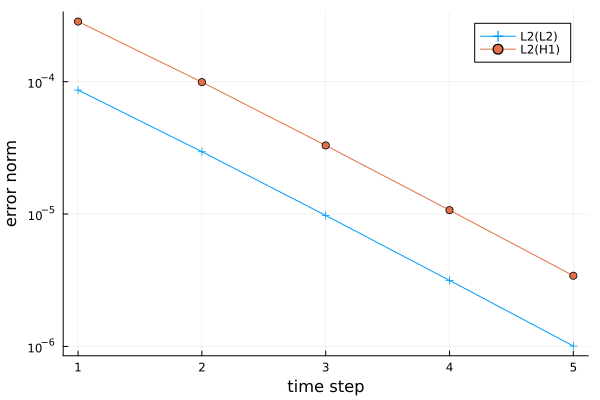

In [405]:
using Plots
println("L2: ", eL2)
println("H1: ", eH1)
taus = [ 1,2,3,4,5]
plot(taus,[eL2 eH1],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")

The discrete convolution:
$$
\partial_t^\alpha (t_n) = \frac{1}{\tau^\alpha} \sum_{j=1}^{n+1} \omega_j^\alpha \Big[u(t_{n-j+1}) - u(0)  \Big]
$$
with 
<!-- $$ -->
<!-- \omega_0^\alpha = 1; \quad \omega_j^\alpha = - \frac{\alpha -j + 1}{j}, \quad j=1,\ldots . -->
<!-- $$ -->

$$
\omega_1^\alpha = 1; \quad \omega_j^\alpha = \frac{j-α-2}{j-1} ω_{j-1}^α, \quad j=2,\ldots .
$$

The following scheme is implemented:

$$
 \displaystyle \left(\frac{1}{τ^α} ω_1 M + A\right)u^n = f^n + \frac{1}{τ^α} \sum_{j=1}^{n} ω_j M u^1 - \frac{1}{τ^α} \sum_{j=2}^{n} ω_j M u^{n-j+1}
$$

In [78]:
module FractionalEM

using LinearAlgebra
using Printf
using Jacobi
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using SpecialFunctions
#using Plots
#using PyPlot

"""
    ReactionConvectionDiffusionOperator(α, β, ϵ)

TBW
"""
function ReactionConvectionDiffusionOperator(γ, β, ϵ)
    function action_kernel!(result, input, x, t)
        β.x = x
        β.time = t
        eval_data!( γ )
        eval_data!( β )
        # α * u_h + β_1 * ∇_xu_h + β_2 ∇_y u_h
        result[1] = γ.val[1] * input[1] + β.val[1] * input[2] + β.val[2] * input[3]
        # Laplacian
        result[2] = ϵ * input[2]
        result[3] = ϵ * input[3]
        return nothing
    end
    action = Action(action_kernel!, [3, 3], dependencies = "XT", bonus_quadorder = max(γ.bonus_quadorder, β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity, Gradient}, OperatorPair{Identity, Gradient}], action;
    name=" ϵ(∇ u, ∇ v) + (γ u + β⋅∇u, v)", transposed_assembly = true)
end


"""
    get_problem_data(ν)

TBW
"""
function get_problem_data(ϵ, p=1.0, α=1.0)
    γ = DataFunction([0.0]; name = "γ")
    β = DataFunction([0.0,0.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = 1 + x[1]^2 + x[2]^2 + 1.2*t^p
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        dt_u = (1 + x[1]^2 + x[2]^2)*t^(-α)/gamma(1-α) + 1.2*gamma(p+1)/gamma(p-α+1)*t^(p-α)
        result[1] = dt_u-ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # γ * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
end

function main(;ϵ = 1, verbosity = 0, nrefinements=2, T0 = 0, Tf=1, nsteps=2, α = 1)
    # generating fractional derivative data
    ω = zeros(nsteps+1)
    ω[1] = 1.0
    ω[2] = -α
    for j=3:nsteps+1
        ω[j] = (j-2-α)/(j-1)*ω[j-1]
    end
    @show ω
    # computing the sum of ω
    sum_omega = zeros(nsteps+1)
    sum_omega[1] = ω[1]
    for j=2:nsteps+1
        sum_omega[j] = sum_omega[j-1] + ω[j]
    end
    @show  sum_omega;
    
    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    ## negotiate data functions to the package
    γ, β, u, ∇u, f = get_problem_data(ϵ, 1.0, α)
    # choose a finite element type
    FEType = H1Pk{1,2,2}
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = FESpace{FEType}(xgrid)
    Solution = FEVector(FES)
    n_dofs = FES.ndofs
    interpolate!(Solution[1], u; time = 0.0)    

    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
    # @show M.entries
    # println(size(M[1,1]))
    @show FES.ndofs
    A = FEMatrix(FES)
    assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=0.0)
    # @show A.entries

    rhs = FEVector(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
    # @show rhs.entries

    dt = Array{BoundaryData,1}(undef,0)
    push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
    dofs = boundarydata!(Solution[1], dt; time = 0.0)
    
    t0 = T0
    tau = (Tf - T0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES.ndofs, 1)
    Mu0 = zeros(Float64, FES.ndofs)    

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)

    SolVector = Array{FEVector{Float64}}([])
    push!(SolVector, Solution)

    # @show norm(Solution.entries - SolVector[1].entries)
    
    # time loop
    scale = tau^α
    oldL2 = zero(Float64); oldh1 = zero(Float64)
    eL2 = zero(Float64); eh1 = zero(Float64)

    Mu0[:] = M.entries*Solution.entries
    time_iter = 1
    
    ## BEGIN DEBUG
    Sol0 = FEVector(FES)
    n_dofs = FES.ndofs
    t0 = t0 + tau
    interpolate!(Sol0[1], u; time = 0.0)
    fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
    addblock!(SystemMatrix[1, 1], M[1, 1]; factor= ω[1]/scale)
    addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
    
    fill!(SystemRHS.entries, 0)
    fill!(rhs.entries, 0)
    assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
    V1[:, 1] = rhs.entries
    addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
    addblock!(SystemRHS[1], Mu0; factor= ω[1]/scale)
    
    flush!(SystemMatrix.entries)
    #@show SystemRHS.entries
    dofs = boundarydata!(SystemSol[1], dt; time = t0)
    for dof in dofs
      SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
      SystemMatrix[1,1][dof,dof] = 1e60
    end
        
    SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
    
    for j = 1 : n_dofs 
        Solution[1][j] = SystemSol[1][j]
    end
    L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
    l2 = evaluate(L2Error_u, Solution[1])
    @show sqrt(l2)

    ## END DEBUG
    
    # @show scale
    # while t0 <= Tf-1e-10
    #     t0 = t0 + tau
    #     time_iter += 1
    #     # assemble rhs 
    #     fill!(SystemRHS.entries, 0)
    #     fill!(rhs.entries, 0)
    #     assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
    #     V1[:, 1] = rhs.entries

    #     fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
    #     fill!(A.entries.cscmatrix.nzval, 0)
    #     # assembling the matrices with coefficients depending on time     
    #     assemble_operator!(A[1, 1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=t0 )
    #     addblock!(SystemMatrix[1, 1], M[1, 1]; factor= ω[1]/scale)
    #     addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
    #     #@info "Preparing the rhs with right coefficients"
    #     # rhs at current time 
    #     addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
    #     # 1/tau^α * ∑ ω_j^α M u^0 
    #     # addblock!(SystemRHS[1], Mu0; factor= sum_omega[time_iter-1]/scale)
    #     for j=1:time_iter-1  
    #         addblock!(SystemRHS[1], Mu0; factor= ω[j]/scale)
    #     end
    #     # @show sum_omega[time_iter-1] # please check me once again
    #     # 1/τ^α * ∑_j=2^{n-1} ω_{n-j+1}^ℵ M u^j 
    #     for j=2:time_iter-1 
    #         addblock!(SystemRHS[1], M.entries*SolVector[time_iter-j+1].entries; factor= -ω[j]/scale)
    #     end

    #     flush!(SystemMatrix.entries)      
    #     #@show SystemRHS.entries
    #     dofs = boundarydata!(SystemSol[1], dt; time = t0)        
    #     for dof in dofs
    #       SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
    #       SystemMatrix[1,1][dof,dof] = 1e60
    #     end
        
    #     SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
        
    #     for j = 1 : n_dofs 
    #         Solution[1][j] = SystemSol[1][j]
    #     end

    #     push!(SolVector, Solution)

    #     L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
    #     l2 = evaluate(L2Error_u, Solution[1])
    #     eL2 += (l2 + oldL2) * tau * 0.5
    #     oldL2 = l2

    #     h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
    #     h1 = evaluate(h1erro, Solution[1])
    #     eh1 += (h1 + oldh1) * tau * 0.5
    #     oldh1 = h1
        
    #     # p = GridVisualizer(; Plotter = PyPlot, layout = (1,3), clear = true, resolution = (1500,500))
    #     # scalarplot!(p[1,1], xgrid, view(nodevalues(Solution[1]),1,:), levels = 7, title = "u_h")
    #     # scalarplot!(p[1,2], xgrid, view(nodevalues(Solution[1], Gradient; abs = true),1,:), levels = 7, colorbarticks = 9, title = "∇u_h (abs + quiver)")
    #     # vectorplot!(p[1,2], xgrid, evaluate(PointEvaluator(Solution[1], Gradient)), vscale = 0.8, clear = false)

    #     @show sqrt(l2), sqrt(h1)
    # end
    @show (sqrt(eL2), sqrt(eh1))
    (sqrt(eL2), sqrt(eh1))
end

end

Main.FractionalEM

In [231]:
Main.FractionalEM.main(;nrefinements=2, T0 = 0, Tf=1, nsteps=20, α = 0.5)

MethodError: MethodError: no method matching main(; nrefinements=2, T0=0, Tf=1, nsteps=20, α=0.5)

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

Closest candidates are:
  main(; ϵ, nrefinements, nsteps, Tf, α, verbosity) at ~/OneDrive/ResearchWork/codes/JuliaFE_Julia23/my_examples/FractionalFEM.ipynb:56 got unsupported keyword argument "T0"

In [63]:
(2^0.5-1)/gamma(1.5)

0.46738995451021825

In [5]:
ns = [10 20 40 80 160]
ns = [2]
eL2=[]; eH1=[];
for n in ns
    el2, eh1 = Main.FractionalEM.main(;nrefinements=2, 
        T0 = 0, Tf=1, nsteps=n, α = 0.5)
    push!(eL2, el2)
    push!(eH1, eh1)
end

UndefVarError: UndefVarError: main not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [6]:
ns = [10]
eL2=[]; eH1=[];
for n in ns
    el2, eh1 = Main.FractionalEM.main(;nrefinements=2, 
        T0 = 0, Tf=1, nsteps=n, α = 1)
    push!(eL2, el2)
    push!(eH1, eh1)
end

UndefVarError: UndefVarError: main not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.
